# Combatting Partisan Homogenization in New Content Recommenders - Baselines(BERT)

In [1]:
# to do
# test with our prototypes and our actual topic labelled data
# use immigration and guns topic, prototypes have to have differing stance variation

## Table of Contents 
### [Clustering Documents, Filtering and Vectorization](#Clustering_Documents_Filtering_Vectorization)
### [Baseline 1 - (Cluster Similarity vs Model Performance)](#Cluster_Similarity_vs_Model_Performance)
### [Baseline 2 - (Online Setting Performance)](#Online_Setting_Performance)
### [Baseline 3 - (Single Cluster Online Setting Performance)](#Single_Cluster_Online_Setting_Performance)
### [Baseline 4 - (Regularization vs Online Setting Performance)](#Regularization_vs_Online_Setting_Performance)
### [Baseline 5 - (Learning Rate vs Online Setting Performance)](#Learning_Rate_vs_Online_Setting_Performance)
### [Baseline 6 - (Online Setting Mixed Data Performance)](#Online_Setting_Mixed_Data_Performance)
### [Baseline 7 - (Learning Rate vs Online Setting Mixed Data Performance)](#Learning_Rate_vs_Online_Setting_Mixed_Data_Performance)

#### Important:
* Heterogenous User:
    * Conservative on Cluster 1 but Liberal on Cluster 2
* Homogeneous User:
    * Conservative on Cluster 1 and Cluster 2

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

In [4]:
from general_utils import timer

from config import RANDOM_SEED

from bert_utils import load_bert_output

from preprocess_utils import preprocess_texts, tfidf_vectorization, dimensionality_reduction

from clustering_utils import run_clustering, get_cluster_sizes, score_cluster, get_cluster_pairs, get_pairwise_dist, cluster2doc, filter_clusters, get_top_100_clusterpairs

from data_utils import load_data, sample_data, balanced_sampling, create_train_test

from metrics_utils import calculate_avg_precision, calculate_map, get_scores, get_scores_wot, calculate_avg_precision_param_variation, calculate_map_param_variation

from model_utils import ( run_model, 
                         run_bs1_train_all, 
                         run_online_setting_active, 
                         run_bs2_train_all, 
                         run_bs3_train_all, 
                         run_bs4_train_all, 
                         run_bs5_train_all, 
                         run_bs6_train_all, 
                         run_bs7_train_all)

from plotters_baseline import ( plot_size_dist, 
                               bsl1_sim_vs_score_all_users, 
                               regularization_plot_helper, 
                               plot_regularization_vs_metrics_at_k, 
                               combine_scores_reg_vs_metrics_at_k, 
                               plot_regularization_vs_metrics_at_k_cumu, 
                               plot_lr_vs_metrics_at_k, 
                               plot_lr_vs_metrics_at_k_cumu, 
                               plot_online_setting_per_clusterpair, 
                               plot_helper_all_cp, 
                               plot_all_cp_online, 
                               plot_all_cp_singlecluster, 
                               plot_helper_scp, 
                               plot_single_cluster_performance, 
                               plot_mixed_data_all_cp_perf, 
                               plot_helper_md, 
                               plot_prec_sep, 
                               plot_mixed_data_performance_per_cluster, 
                               plot_mixed_data_performance, 
                               combine_scores_cumu_online_setting,
                               plot_mixed_cluster_cumulative, 
                               plot_online_learning_cumulative, 
                               plot_single_cluster_cumulative, 
                               plot_mixed_data_all_cp_perf, 
                               lr_mixed_plot_helper, 
                               plot_lr_vs_metrics_at_k_mixed, 
                               plot_mixed_data_all_cp_precis_lr, 
                               plot_mixed_cluster_cumulative_per_cluster  )   

....... Initializing Settings ..... 
Random_Seed Chosen : 15112


In [5]:
warnings.filterwarnings('ignore')

In [6]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.grid'] = True

# Main Components

1) Data Loading  
2) Sampling  
3) Text Preprocessing  
4) Vectorization  
5) Dimensionality Reductions  
6) Clustering  
7) Clustering Performance Check  
8) Cluster Filtering  
9) Pairwise Selection  
10) Model Training and Performance  
11) Pairwise score analysis  

## Clustering Documents, Filtering and Vectorization <a class="anchor" id="Clustering_Documents_Filtering_Vectorization"></a>

Index(['article_id', 'url', 'title', 'text', 'source', 'source_partisan_score',
       'tweet_id', 'tweet_screen_name', 'tweet_created_at', 'tweet_text'],
      dtype='object')
Df original shape : (921037, 10)
Df shape after dropping nan text : (919430, 10)
Df shape after dropping duplicate articles based on title : (912084, 10)
Df shape after dropping 0 stance articles : (630425, 10)

Finished running 'load_data' in 0.4248 mins


Finished running 'sample_data' in 0.0018 mins

Sampled Size: 100000
Running : select_first10
Running : to_lower
Running : remove_punc
Running : remove_small_words
Running : remove_spaces

Finished running 'preprocess_texts' in 0.3129 mins

First Ten Files : ['/media/karthikshivaram/Extra_disk_1/Bert_model_outputs/0.npy', '/media/karthikshivaram/Extra_disk_1/Bert_model_outputs/1.npy', '/media/karthikshivaram/Extra_disk_1/Bert_model_outputs/2.npy', '/media/karthikshivaram/Extra_disk_1/Bert_model_outputs/3.npy', '/media/karthikshivaram/Extra_disk_1/Bert_model_ou

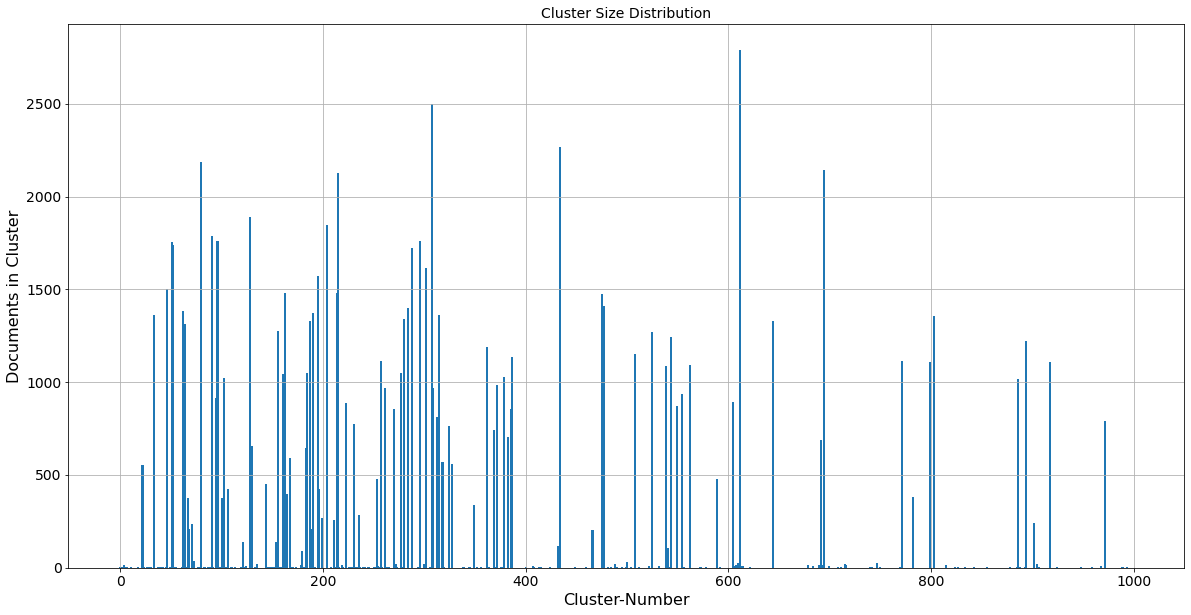


Finished running 'get_pairwise_dist' in 0.0001 mins


Number of Cluster Pairs : 499500

Finished running 'get_cluster_pairs' in 0.0018 mins

499500


In [7]:
path = "../articles.csv"

main_df = load_data(path)

sampled_df = sample_data(df=main_df,sample_size=100000,seed=RANDOM_SEED)
print("Sampled Size: %s" %str(sampled_df.shape[0]))

sampled_df["processed_text"] = preprocess_texts(text_lists=sampled_df["text"])

reduced_vectors =  load_bert_output(folder1="/media/karthikshivaram/Extra_disk_1/Bert_model_outputs",
                              folder2="/media/karthikshivaram/Extra_Disk_2/Bert_model_outputs",
                              layer=3,aggregation="mean + max")

print("Bert Embedding Output Shape : %s" %str(reduced_vectors.shape))

clusters,cluster_clf = run_clustering(vectors=reduced_vectors,seed=RANDOM_SEED,num_clusters=1000,clus_type="kmeans")

cluster_sizes = get_cluster_sizes(cluster_clf)

plot_size_dist(cluster_sizes)

cluster_pair_dist_mat = get_pairwise_dist(cluster_clf,dist_type="cosine")

cluster_pairs = get_cluster_pairs(num_clusters=1000)
print(len(cluster_pairs))

In [8]:
doc_2_cluster_map = cluster2doc(num_texts=sampled_df.shape[0],cluster_labels=cluster_clf.labels_)


Finished running 'cluster2doc' in 0.0003 mins



In [9]:
filtered_cluster_pairs = filter_clusters(cluster_pairs=cluster_pairs,
                                        doc_2_cluster_map=doc_2_cluster_map,
                                        cluster_sizes=cluster_sizes,
                                        partisan_scores=sampled_df["binary_ps"].tolist(),
                                        min_size=450,
                                        max_size=5000,
                                        min_partisan_size=0.4)

print("Filtered CLustered Pairs : %s" %str(len(filtered_cluster_pairs)))


Finished running 'filter_clusters' in 0.0980 mins

Filtered CLustered Pairs : 595


In [10]:
top100 = get_top_100_clusterpairs(cluster_pairs=filtered_cluster_pairs,dist_matrix=cluster_pair_dist_mat,reverse=True)


Finished running 'get_top_100_clusterpairs' in 0.0000 mins



## Baseline 1 : <a class="anchor" id="Cluster_Similarity_vs_Model_Performance"></a>

In [11]:
df_result = run_bs1_train_all(X = reduced_vectors,
                          cluster_2_doc_map = doc_2_cluster_map ,
                          df = sampled_df ,
                          cluster_pairs = top100,
                          cosine_mat = cluster_pair_dist_mat,
                          thresholds = [0.5,0.7,0.9],
                          user_type="Heterogeneous")

Training model for cluster pair : 0

Finished running 'run_model' in 0.2481 mins

Training model for cluster pair : 1

Finished running 'run_model' in 0.3552 mins

Training model for cluster pair : 2

Finished running 'run_model' in 0.2078 mins

Training model for cluster pair : 3

Finished running 'run_model' in 0.0339 mins

Training model for cluster pair : 4

Finished running 'run_model' in 0.1550 mins

Training model for cluster pair : 5

Finished running 'run_model' in 0.1454 mins

Training model for cluster pair : 6

Finished running 'run_model' in 0.2372 mins

Training model for cluster pair : 7

Finished running 'run_model' in 0.2142 mins

Training model for cluster pair : 8

Finished running 'run_model' in 0.1832 mins

Training model for cluster pair : 9

Finished running 'run_model' in 0.2183 mins

Training model for cluster pair : 10

Finished running 'run_model' in 0.3432 mins

Training model for cluster pair : 11

Finished running 'run_model' in 0.2141 mins

Training model

In [12]:
df_result_homog = run_bs1_train_all(X = reduced_vectors,
                          cluster_2_doc_map = doc_2_cluster_map ,
                          df = sampled_df ,
                          cluster_pairs = top100,
                          cosine_mat = cluster_pair_dist_mat,
                          thresholds = [0.5,0.7,0.9],
                          user_type="Homogeneous")

Training model for cluster pair : 0

Finished running 'run_model' in 0.2494 mins

Training model for cluster pair : 1

Finished running 'run_model' in 0.3465 mins

Training model for cluster pair : 2

Finished running 'run_model' in 0.2320 mins

Training model for cluster pair : 3

Finished running 'run_model' in 0.0316 mins

Training model for cluster pair : 4

Finished running 'run_model' in 0.1719 mins

Training model for cluster pair : 5

Finished running 'run_model' in 0.1399 mins

Training model for cluster pair : 6

Finished running 'run_model' in 0.2398 mins

Training model for cluster pair : 7

Finished running 'run_model' in 0.2790 mins

Training model for cluster pair : 8

Finished running 'run_model' in 0.1775 mins

Training model for cluster pair : 9

Finished running 'run_model' in 0.2517 mins

Training model for cluster pair : 10

Finished running 'run_model' in 0.3651 mins

Training model for cluster pair : 11

Finished running 'run_model' in 0.2216 mins

Training model

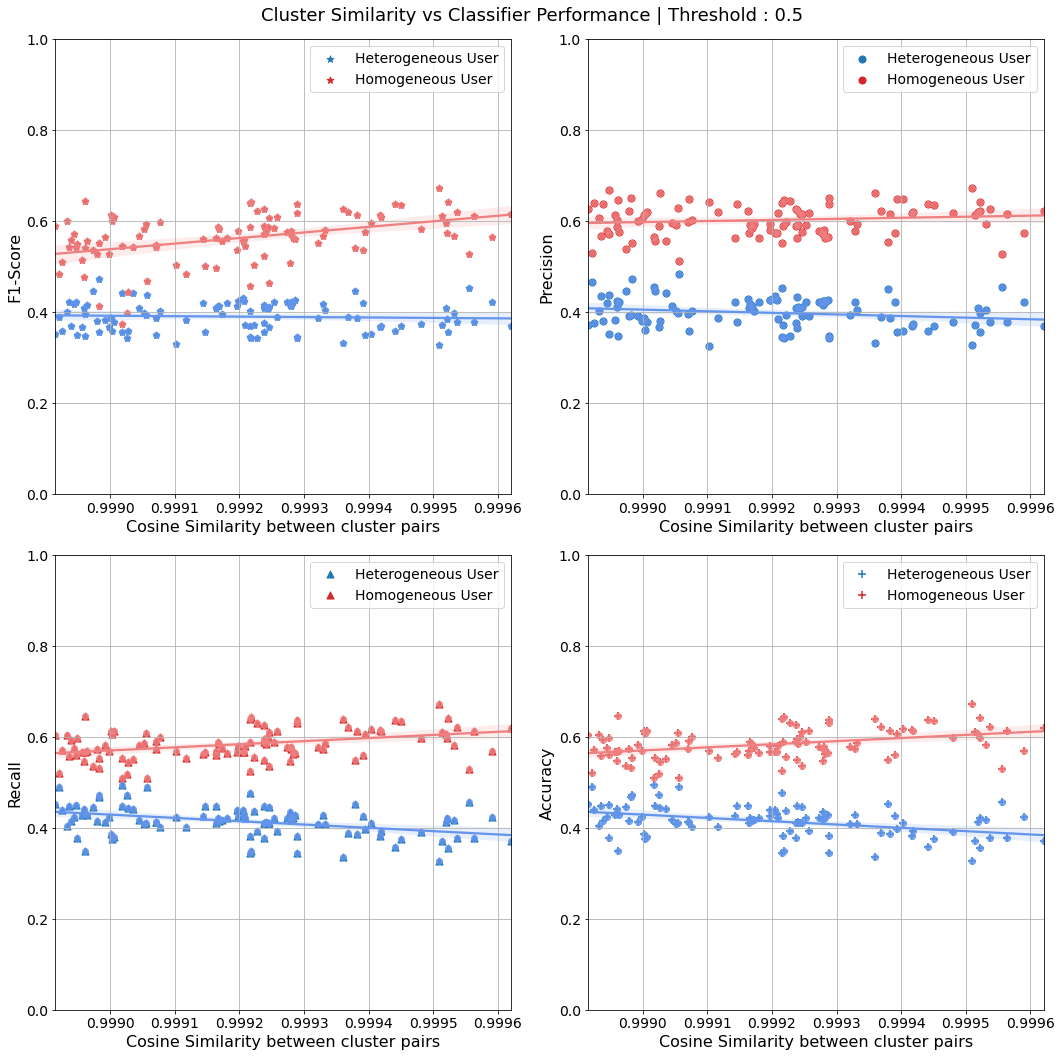


Finished running 'bsl1_sim_vs_score_all_users' in 0.0214 mins



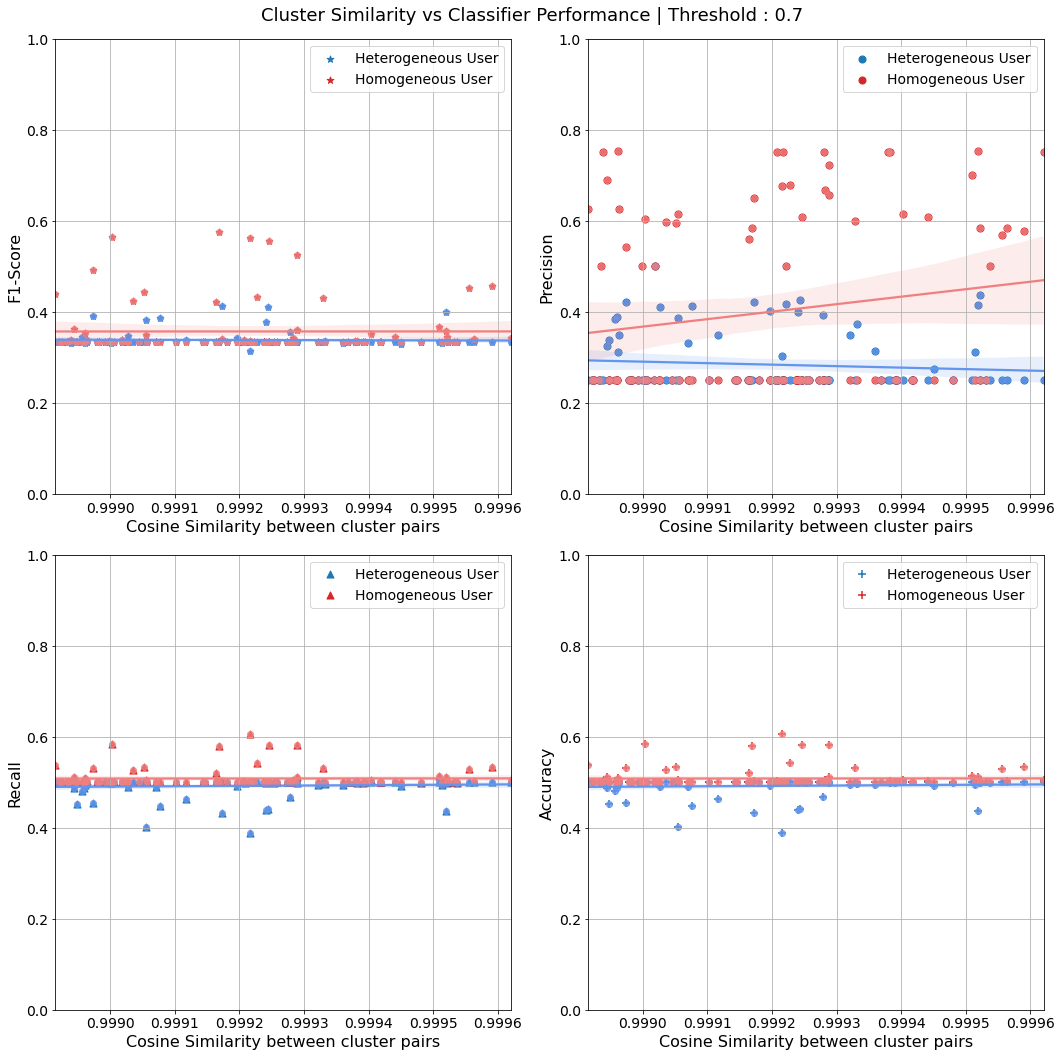


Finished running 'bsl1_sim_vs_score_all_users' in 0.0211 mins



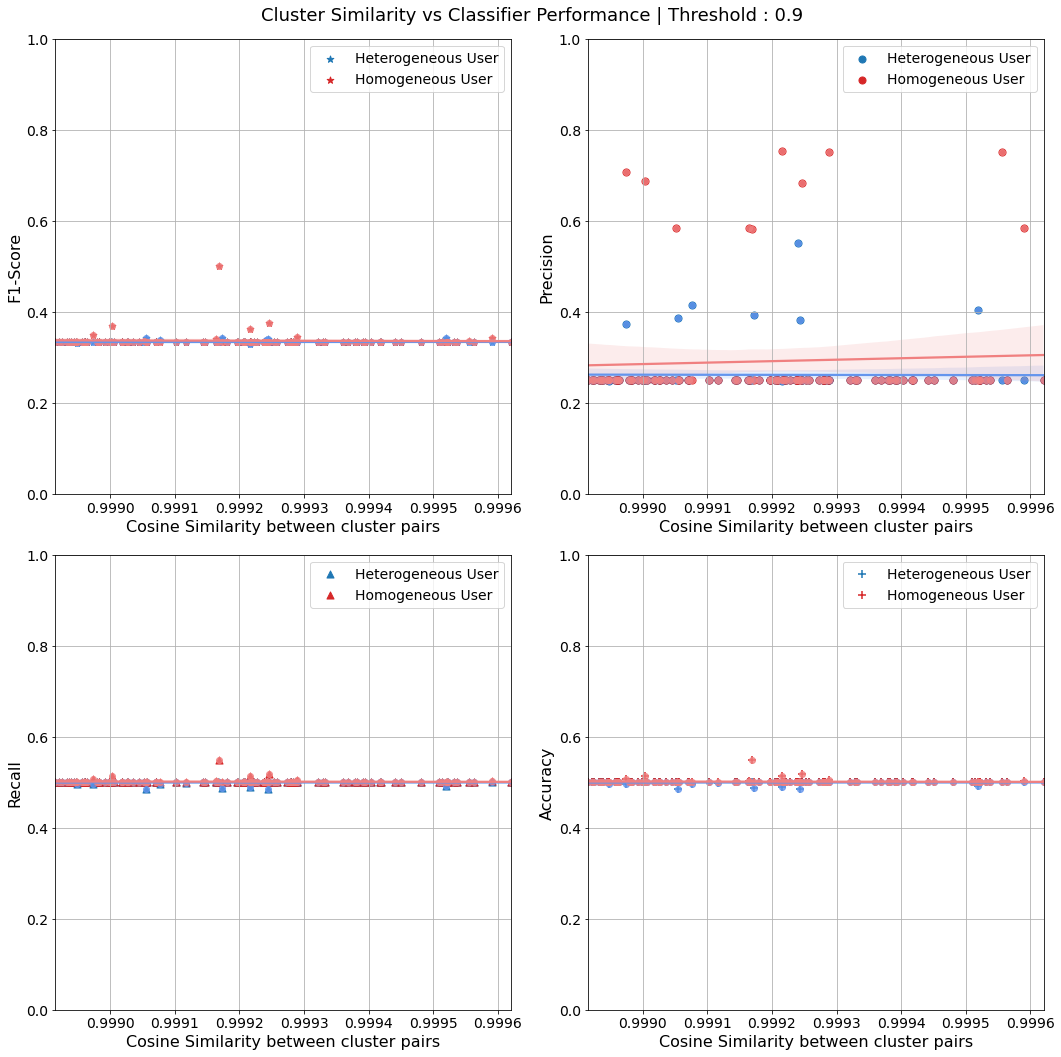


Finished running 'bsl1_sim_vs_score_all_users' in 0.0210 mins



In [13]:
for threshold in [0.5,0.7,0.9]:
    bsl1_sim_vs_score_all_users(df_results_hetero=df_result,
                                df_results_homo=df_result_homog,
                                threshold=threshold)

<!-- ## Online Learning Setting - Active Learning Setting (Performance Measured on Held Out Validation Dataset) -->

## Baseline 2 : <a class="anchor" id="Online_Setting_Performance"></a>

In [14]:
hetero_scores,df_res_map_hetero = run_bs2_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Heterogeneous")

Training model for cluster pair : (91, 549)
Training model for cluster pair : (80, 190)
Training model for cluster pair : (91, 128)
Training model for cluster pair : (231, 525)
Training model for cluster pair : (214, 694)
Training model for cluster pair : (190, 379)
Training model for cluster pair : (96, 156)
Training model for cluster pair : (91, 525)
Training model for cluster pair : (91, 231)
Training model for cluster pair : (91, 886)
Training model for cluster pair : (80, 302)
Training model for cluster pair : (288, 386)
Training model for cluster pair : (91, 694)
Training model for cluster pair : (694, 886)
Training model for cluster pair : (215, 288)
Training model for cluster pair : (525, 886)
Training model for cluster pair : (46, 387)
Training model for cluster pair : (288, 383)
Training model for cluster pair : (215, 803)
Training model for cluster pair : (96, 190)
Training model for cluster pair : (288, 803)
Training model for cluster pair : (215, 315)
Training model for cl

In [15]:
homo_scores, df_res_map_homo =  run_bs2_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Homogeneous")

Training model for cluster pair : (91, 549)
Training model for cluster pair : (80, 190)
Training model for cluster pair : (91, 128)
Training model for cluster pair : (231, 525)
Training model for cluster pair : (214, 694)
Training model for cluster pair : (190, 379)
Training model for cluster pair : (96, 156)
Training model for cluster pair : (91, 525)
Training model for cluster pair : (91, 231)
Training model for cluster pair : (91, 886)
Training model for cluster pair : (80, 302)
Training model for cluster pair : (288, 386)
Training model for cluster pair : (91, 694)
Training model for cluster pair : (694, 886)
Training model for cluster pair : (215, 288)
Training model for cluster pair : (525, 886)
Training model for cluster pair : (46, 387)
Training model for cluster pair : (288, 383)
Training model for cluster pair : (215, 803)
Training model for cluster pair : (96, 190)
Training model for cluster pair : (288, 803)
Training model for cluster pair : (215, 315)
Training model for cl


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins



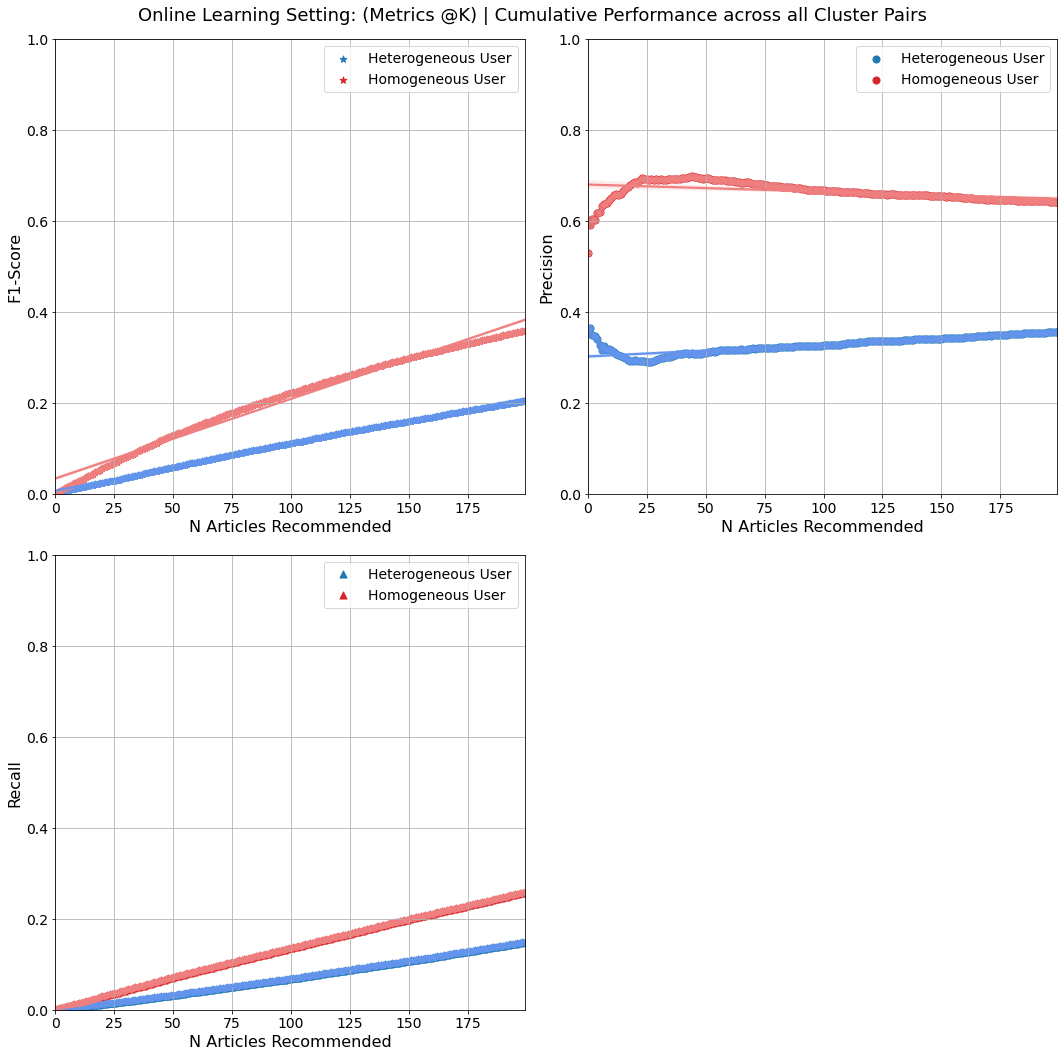


Finished running 'plot_online_setting_per_clusterpair' in 0.0177 mins


Finished running 'plot_online_learning_cumulative' in 0.0178 mins



In [16]:
plot_online_learning_cumulative(homo_scores,hetero_scores,active=False)

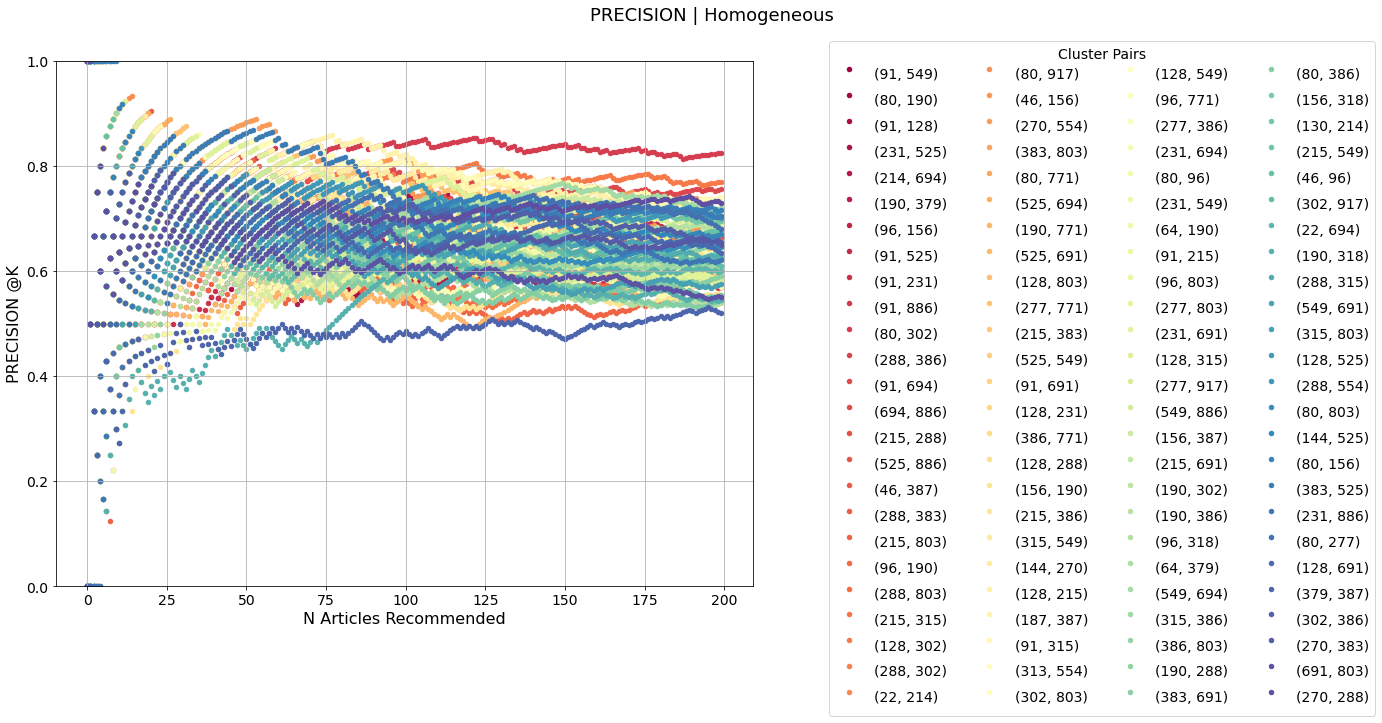


Finished running 'plot_all_cp_online' in 0.0604 mins



In [17]:
plot_all_cp_online(homo_scores,user_type="Homogeneous",metric="precision")

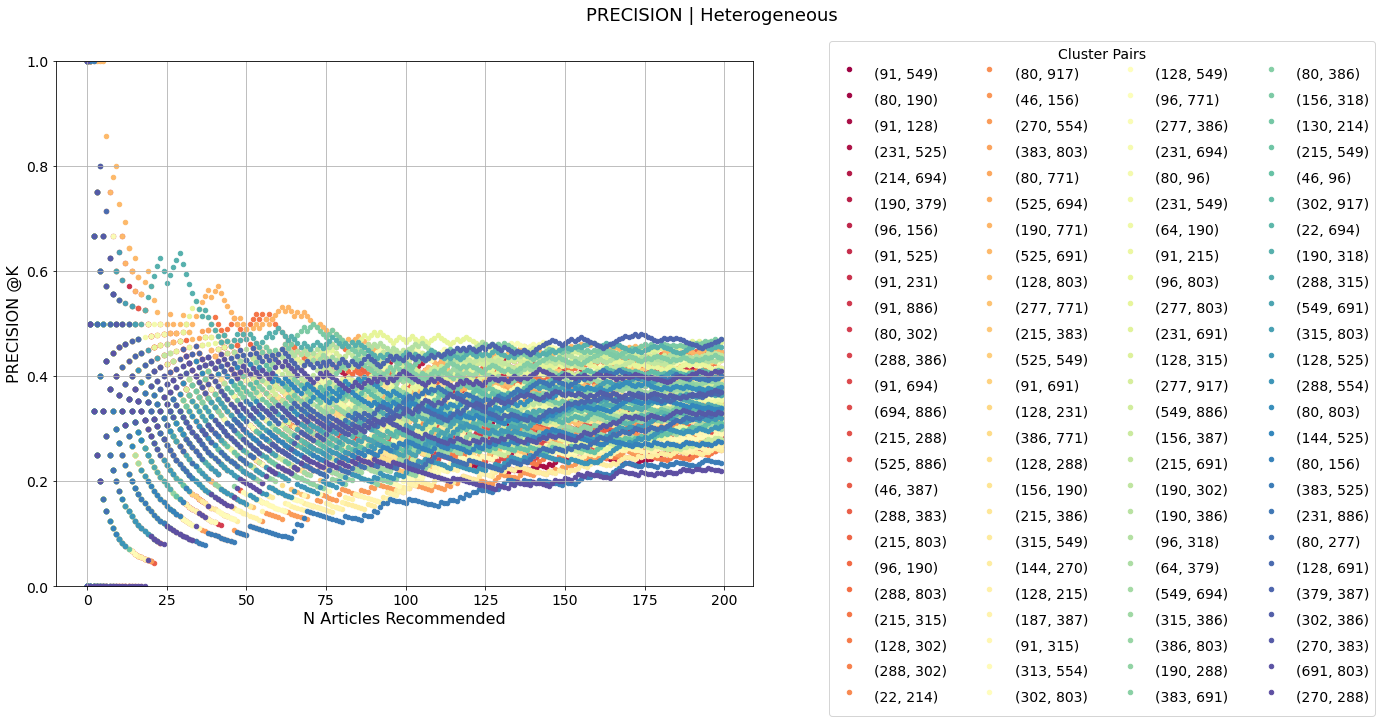


Finished running 'plot_all_cp_online' in 0.0604 mins



In [18]:
plot_all_cp_online(hetero_scores,user_type="Heterogeneous",metric="precision")

In [19]:
avg_presc_homo = calculate_avg_precision(homo_scores,mode="single")

In [20]:
np.mean(avg_presc_homo)

0.6640330608123868

In [21]:
avg_presc_hetero = calculate_avg_precision(hetero_scores,mode="single")

In [22]:
np.mean(avg_presc_hetero)

0.3278963690934845

## Baseline 3 :  <a class="anchor" id="Single_Cluster_Online_Setting_Performance"></a>

In [23]:
hetero_scores = run_bs3_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Heterogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [24]:
homo_scores =  run_bs3_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Homogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins



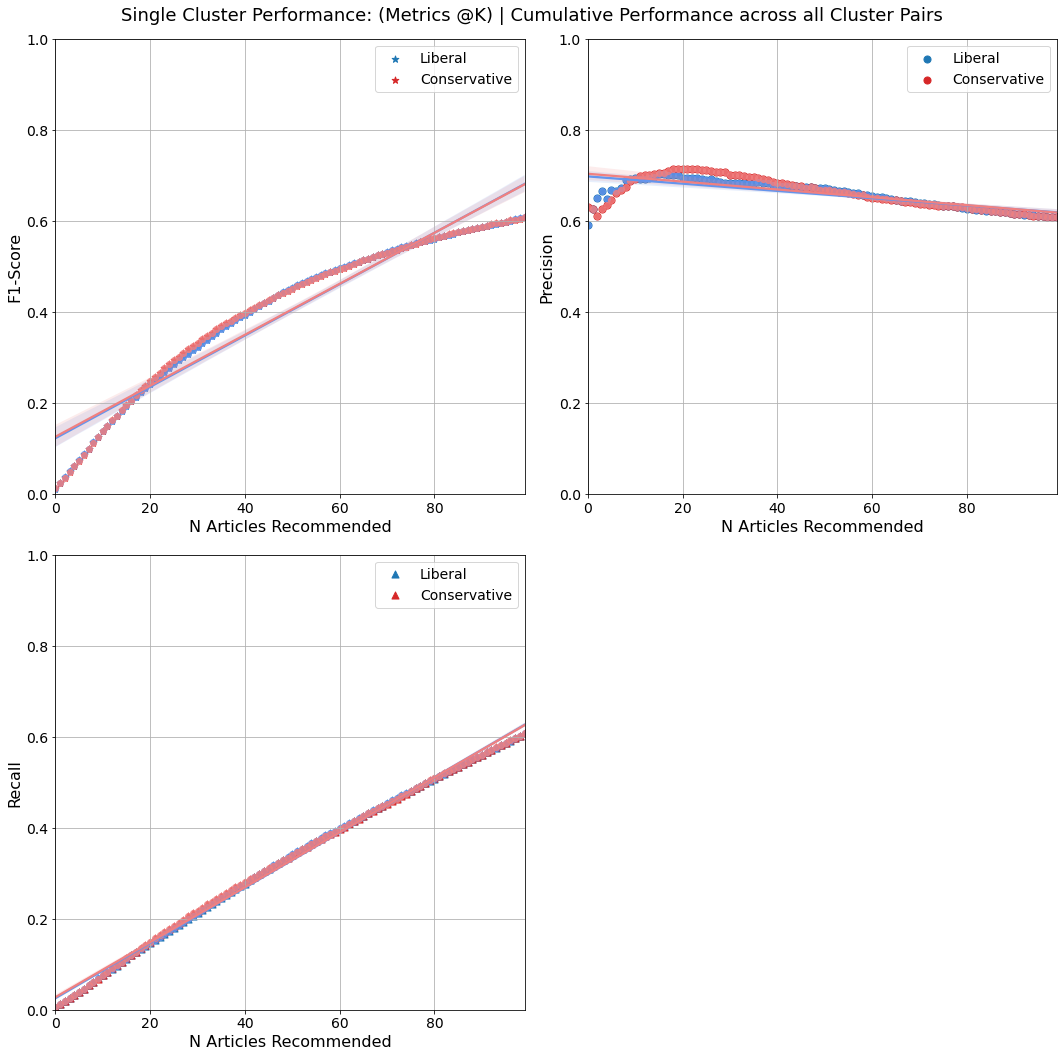


Finished running 'plot_single_cluster_performance' in 0.0161 mins


Finished running 'plot_single_cluster_cumulative' in 0.0161 mins



In [25]:
plot_single_cluster_cumulative(homo_scores,hetero_scores)

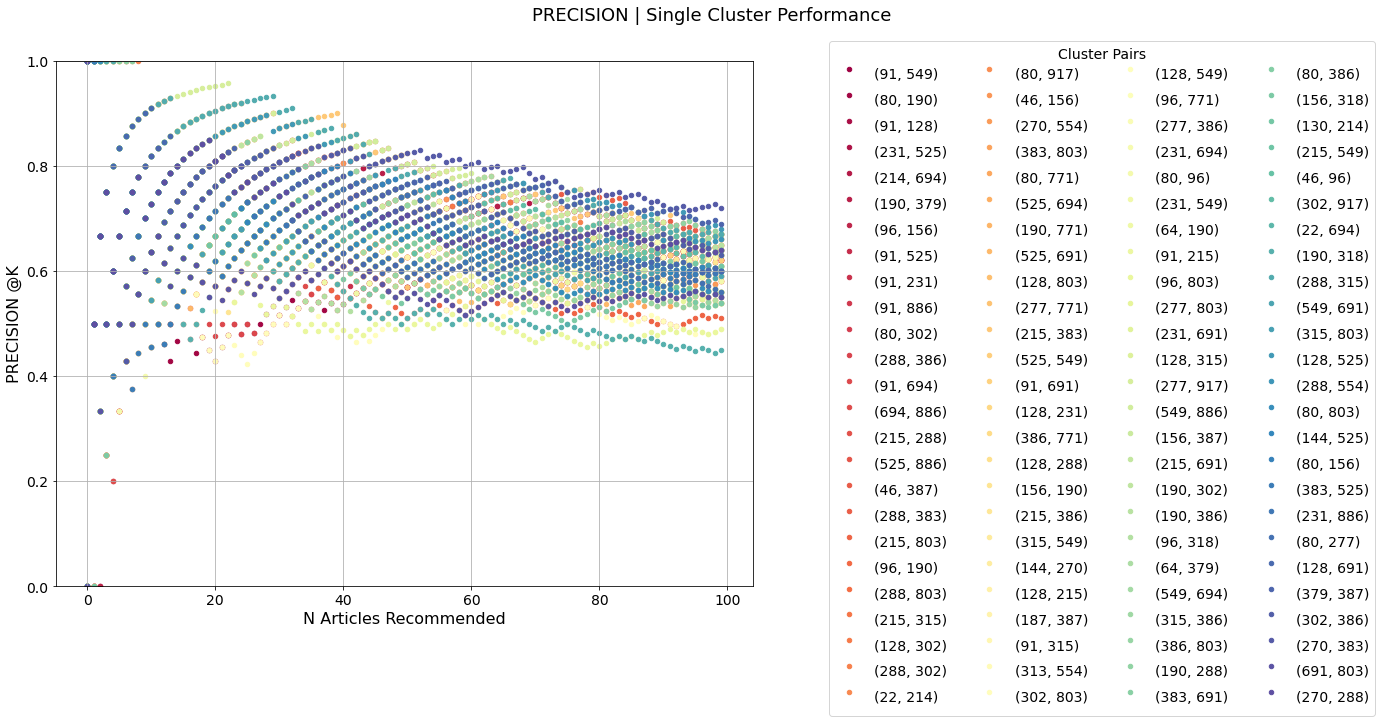


Finished running 'plot_all_cp_singlecluster' in 0.0559 mins



In [26]:
plot_all_cp_singlecluster(homo_scores)

In [27]:
avg_presc_homo = calculate_avg_precision(homo_scores,mode="single")

In [28]:
np.mean(avg_presc_homo)

0.6605894407650365

## Baseline 4: <a class="anchor" id="Regularization_vs_Online_Setting_Performance"></a>

In [29]:
hetero_scores = run_bs4_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous",
                                 reg_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [30]:
homo_scores = run_bs4_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous",
                                 reg_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0003 mins



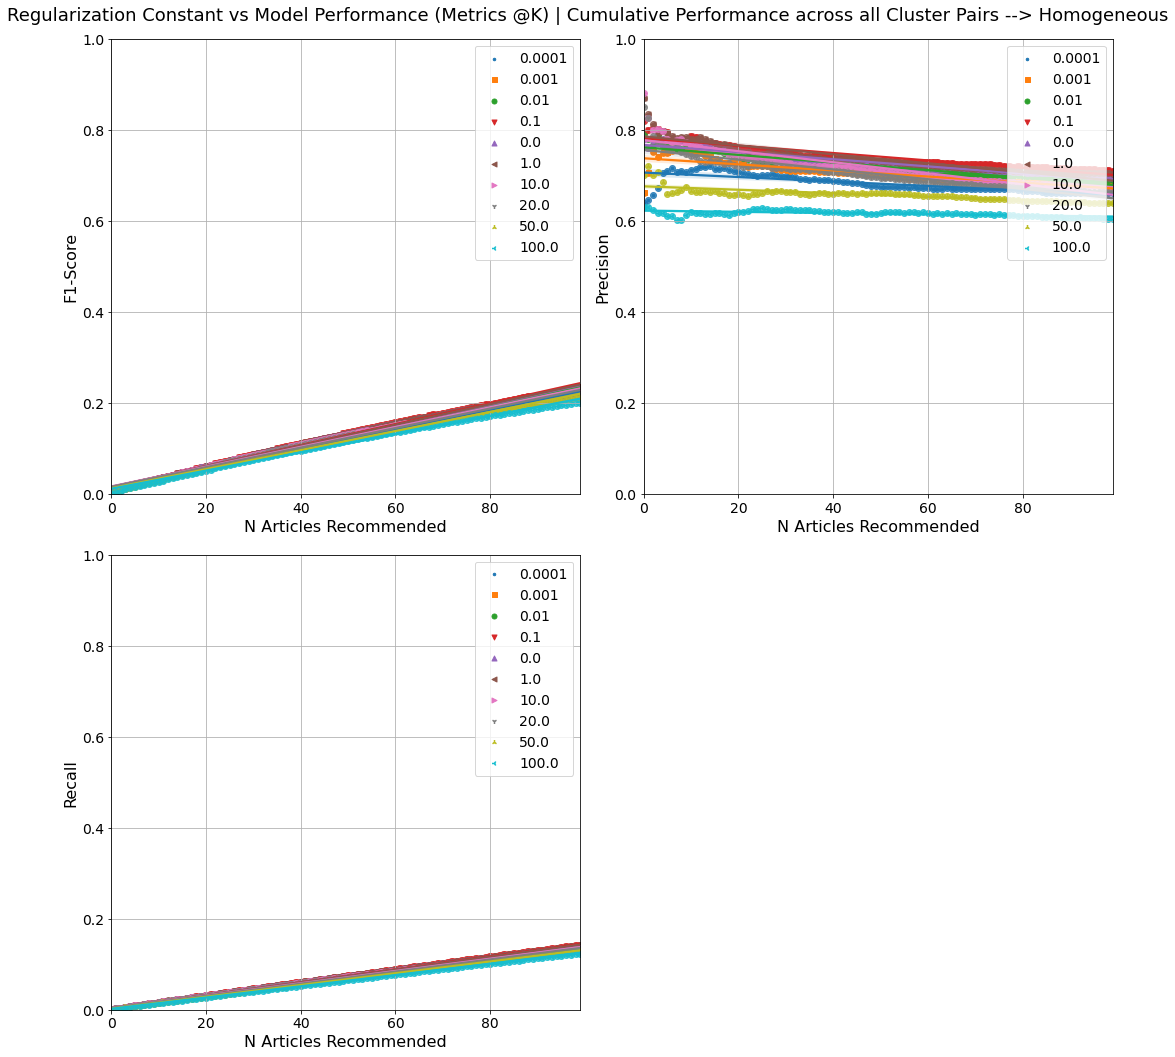


Finished running 'plot_regularization_vs_metrics_at_k' in 0.0580 mins


Finished running 'plot_regularization_vs_metrics_at_k_cumu' in 0.0583 mins



In [31]:
plot_regularization_vs_metrics_at_k_cumu(homo_scores,
                                         regularization_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0],
                                         user_type="Homogeneous")


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0002 mins



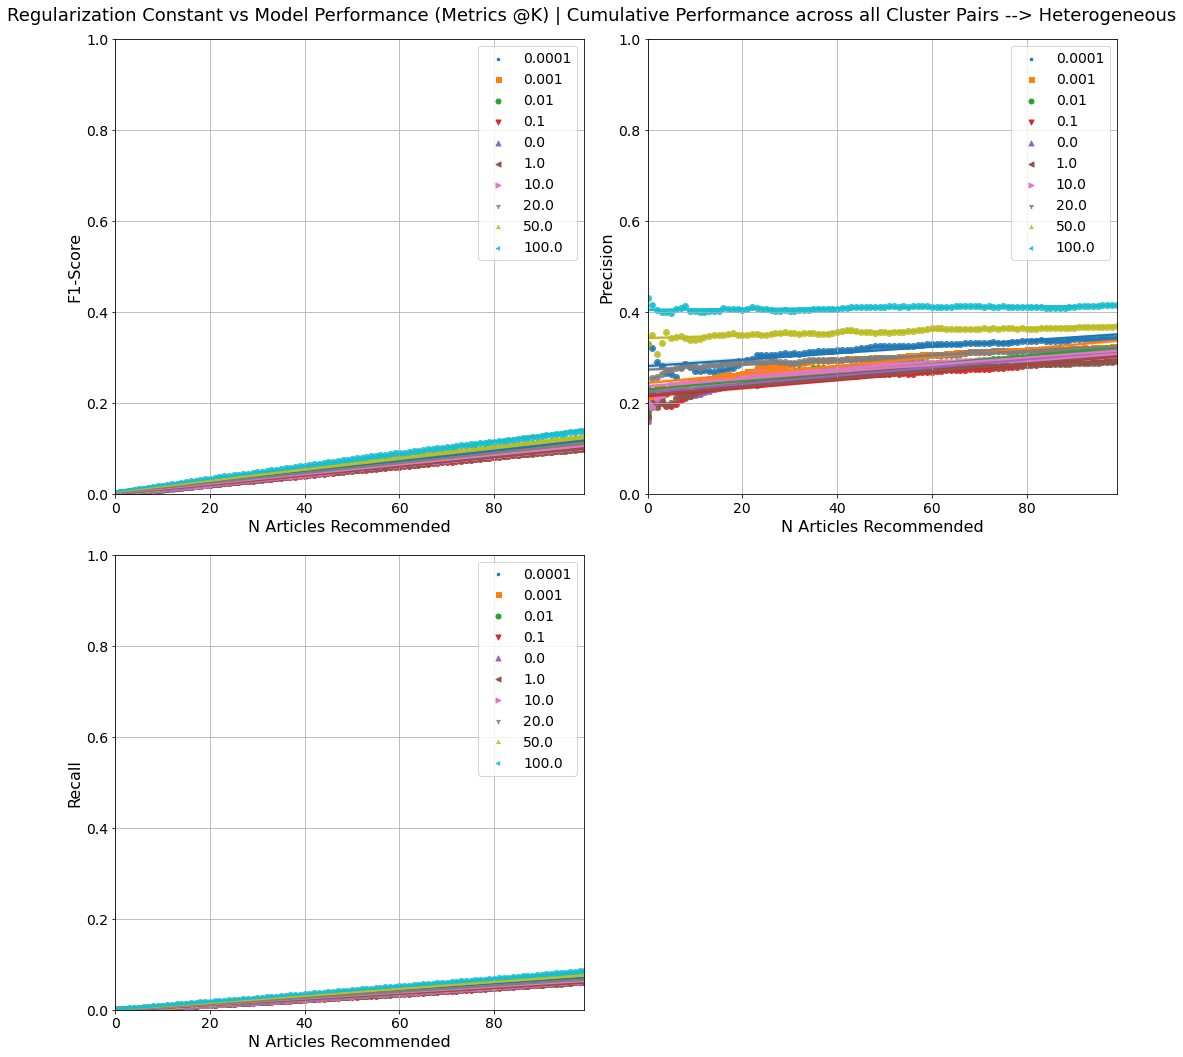


Finished running 'plot_regularization_vs_metrics_at_k' in 0.0566 mins


Finished running 'plot_regularization_vs_metrics_at_k_cumu' in 0.0568 mins



In [32]:
plot_regularization_vs_metrics_at_k_cumu(hetero_scores,
                                         regularization_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

In [33]:
homo_param_res = calculate_avg_precision_param_variation(homo_scores,
                                                         params=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

In [34]:
calculate_map_param_variation(homo_param_res)


Param : 0.0001
0.6815781246063564

Param : 0.001
0.704178027060347

Param : 0.01
0.7200217575701945

Param : 0.1
0.7410881723091731

Param : 0.0
0.7276769319686589

Param : 1.0
0.736671356837899

Param : 10.0
0.7171055472977477

Param : 20.0
0.7025780227591234

Param : 50.0
0.6568731011561478

Param : 100.0
0.6157367107208873


In [35]:
hetero_param_res = calculate_avg_precision_param_variation(hetero_scores,
                                                         params=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

In [36]:
calculate_map_param_variation(hetero_param_res)


Param : 0.0001
0.31566587659690026

Param : 0.001
0.29005209084287487

Param : 0.01
0.2755529250786233

Param : 0.1
0.25790825905378595

Param : 0.0
0.26827030073540215

Param : 1.0
0.2604606020113436

Param : 10.0
0.27573130102643456

Param : 20.0
0.298480989404765

Param : 50.0
0.3561992769762608

Param : 100.0
0.4089033547678575


## Baseline 5 : <a class="anchor" id="Learning_Rate_vs_Online_Setting_Performance"></a>

In [37]:
hetero_scores,df_het_res_100,df_het_res_500 = run_bs5_train_all(X=reduced_vectors,sample_df=sampled_df,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0

*************** CP = (91, 549) , LR = 0.001 ****************
SGDClassifier(eta0=0.001, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (91, 549) , LR = 0.01 ****************
SGDClassifier(eta0=0.01, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (91, 549) , LR = 0.1 ****************
SGDClassifier(eta0=0.1, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (91, 549) , LR = 1.0 ****************
SGDClassifier(eta0=1.0, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (91, 549) , LR = 10 ****************
SGDClassifier(eta0=10, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (91, 549) , LR = 15 ****************
SGDClassifier(eta0=15, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (91, 549) , LR = 20 ************

In [38]:
homo_scores,df_hom_res_100,df_hom_res_500 = run_bs5_train_all(X=reduced_vectors,sample_df=sampled_df,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0

*************** CP = (91, 549) , LR = 0.001 ****************
SGDClassifier(eta0=0.001, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (91, 549) , LR = 0.01 ****************
SGDClassifier(eta0=0.01, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (91, 549) , LR = 0.1 ****************
SGDClassifier(eta0=0.1, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (91, 549) , LR = 1.0 ****************
SGDClassifier(eta0=1.0, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (91, 549) , LR = 10 ****************
SGDClassifier(eta0=10, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (91, 549) , LR = 15 ****************
SGDClassifier(eta0=15, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (91, 549) , LR = 20 ************


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0005 mins



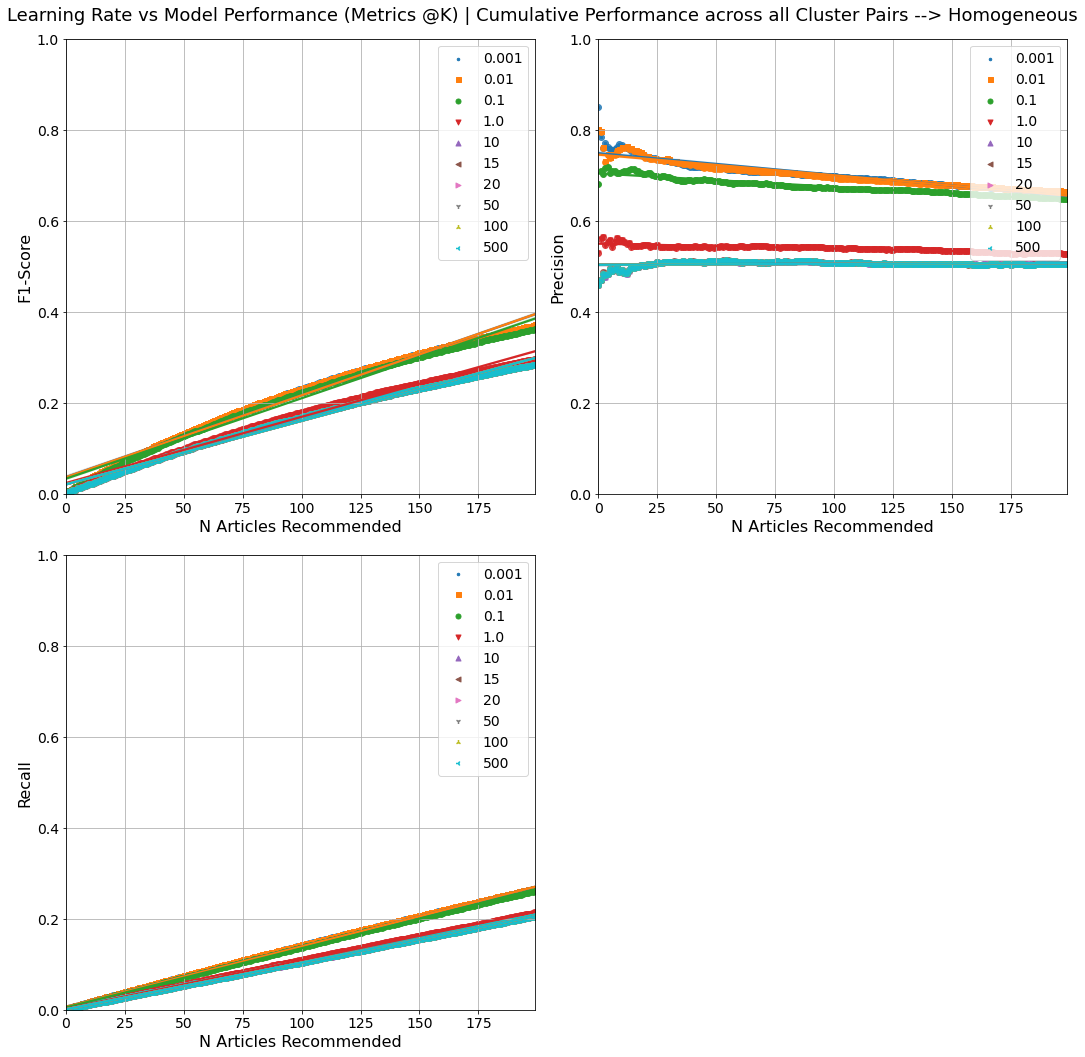


Finished running 'plot_lr_vs_metrics_at_k' in 0.0654 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0658 mins



In [39]:
plot_lr_vs_metrics_at_k_cumu(homo_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
                             user_type="Homogeneous")


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0004 mins



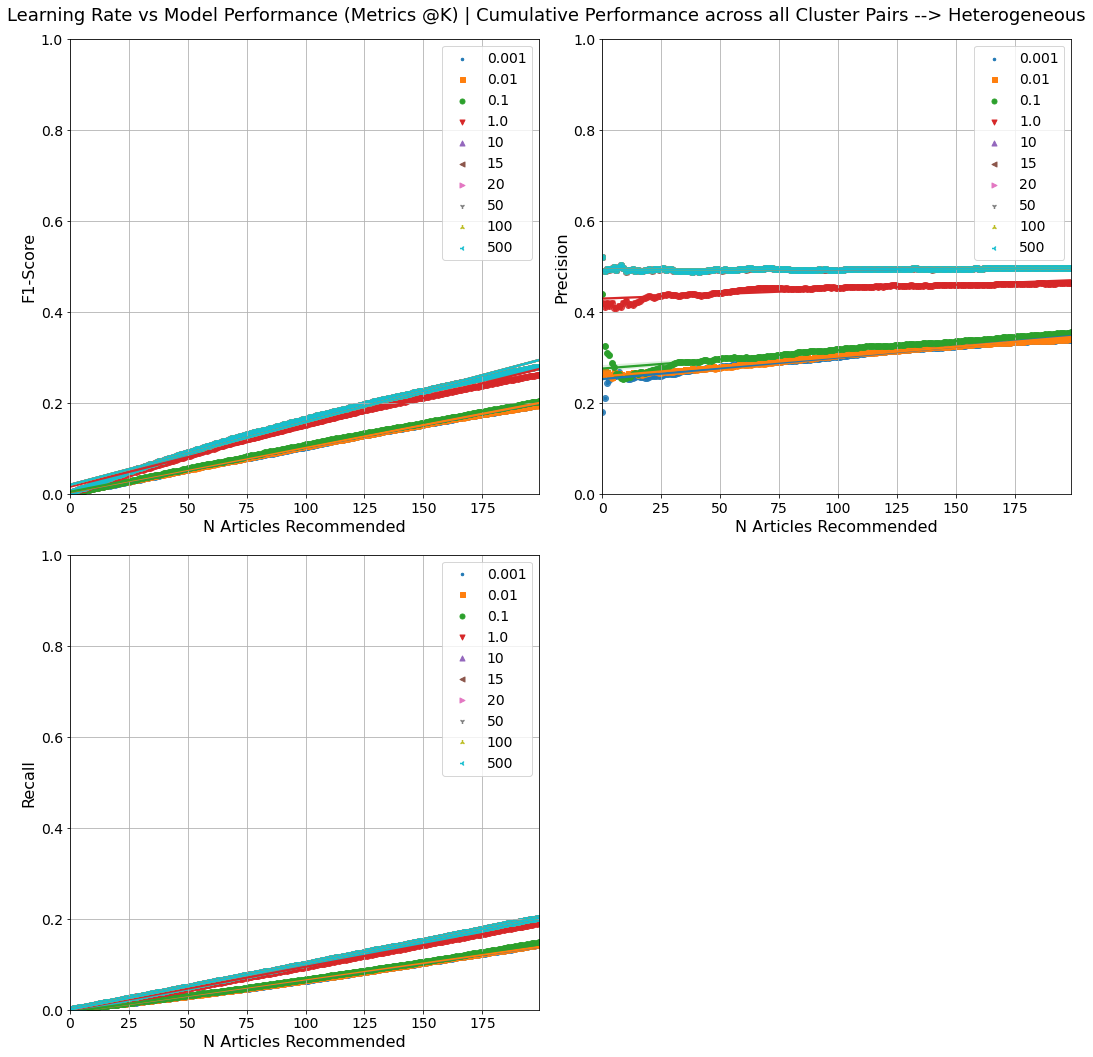


Finished running 'plot_lr_vs_metrics_at_k' in 0.0637 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0642 mins



In [40]:
plot_lr_vs_metrics_at_k_cumu(hetero_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

In [41]:
homo_param_res = calculate_avg_precision_param_variation(homo_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

In [42]:
calculate_map_param_variation(homo_param_res)


Param : 0.001
0.7013534392802971

Param : 0.01
0.7002603988145047

Param : 0.1
0.6746960840778474

Param : 1.0
0.5389953579978143

Param : 10
0.5052066140328599

Param : 15
0.5055645410820336

Param : 20
0.5052557085005511

Param : 50
0.5052557085005511

Param : 100
0.5052557085005511

Param : 500
0.5052557085005511


In [43]:
hetero_param_res = calculate_avg_precision_param_variation(hetero_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

In [44]:
calculate_map_param_variation(hetero_param_res)


Param : 0.001
0.2994774323322267

Param : 0.01
0.3014556664237351

Param : 0.1
0.3154098032306942

Param : 1.0
0.4491682561324709

Param : 10
0.4938815173276674

Param : 15
0.49370380052926177

Param : 20
0.4938815173276674

Param : 50
0.4938815173276674

Param : 100
0.4938815173276674

Param : 500
0.4938815173276674


## Baseline 6: <a class="anchor" id="Online_Setting_Mixed_Data_Performance"></a>

In [45]:
hetero_scores = run_bs6_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [46]:
homo_scores = run_bs6_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [47]:
# homo_scores.keys()

In [48]:
# plot_mixed_data_performance_per_cluster(homo_scores[(585, 712)],hetero_scores[(585, 712)])


Finished running 'combine_scores_mixed_data' in 0.0001 mins


Finished running 'combine_scores_mixed_data' in 0.0001 mins



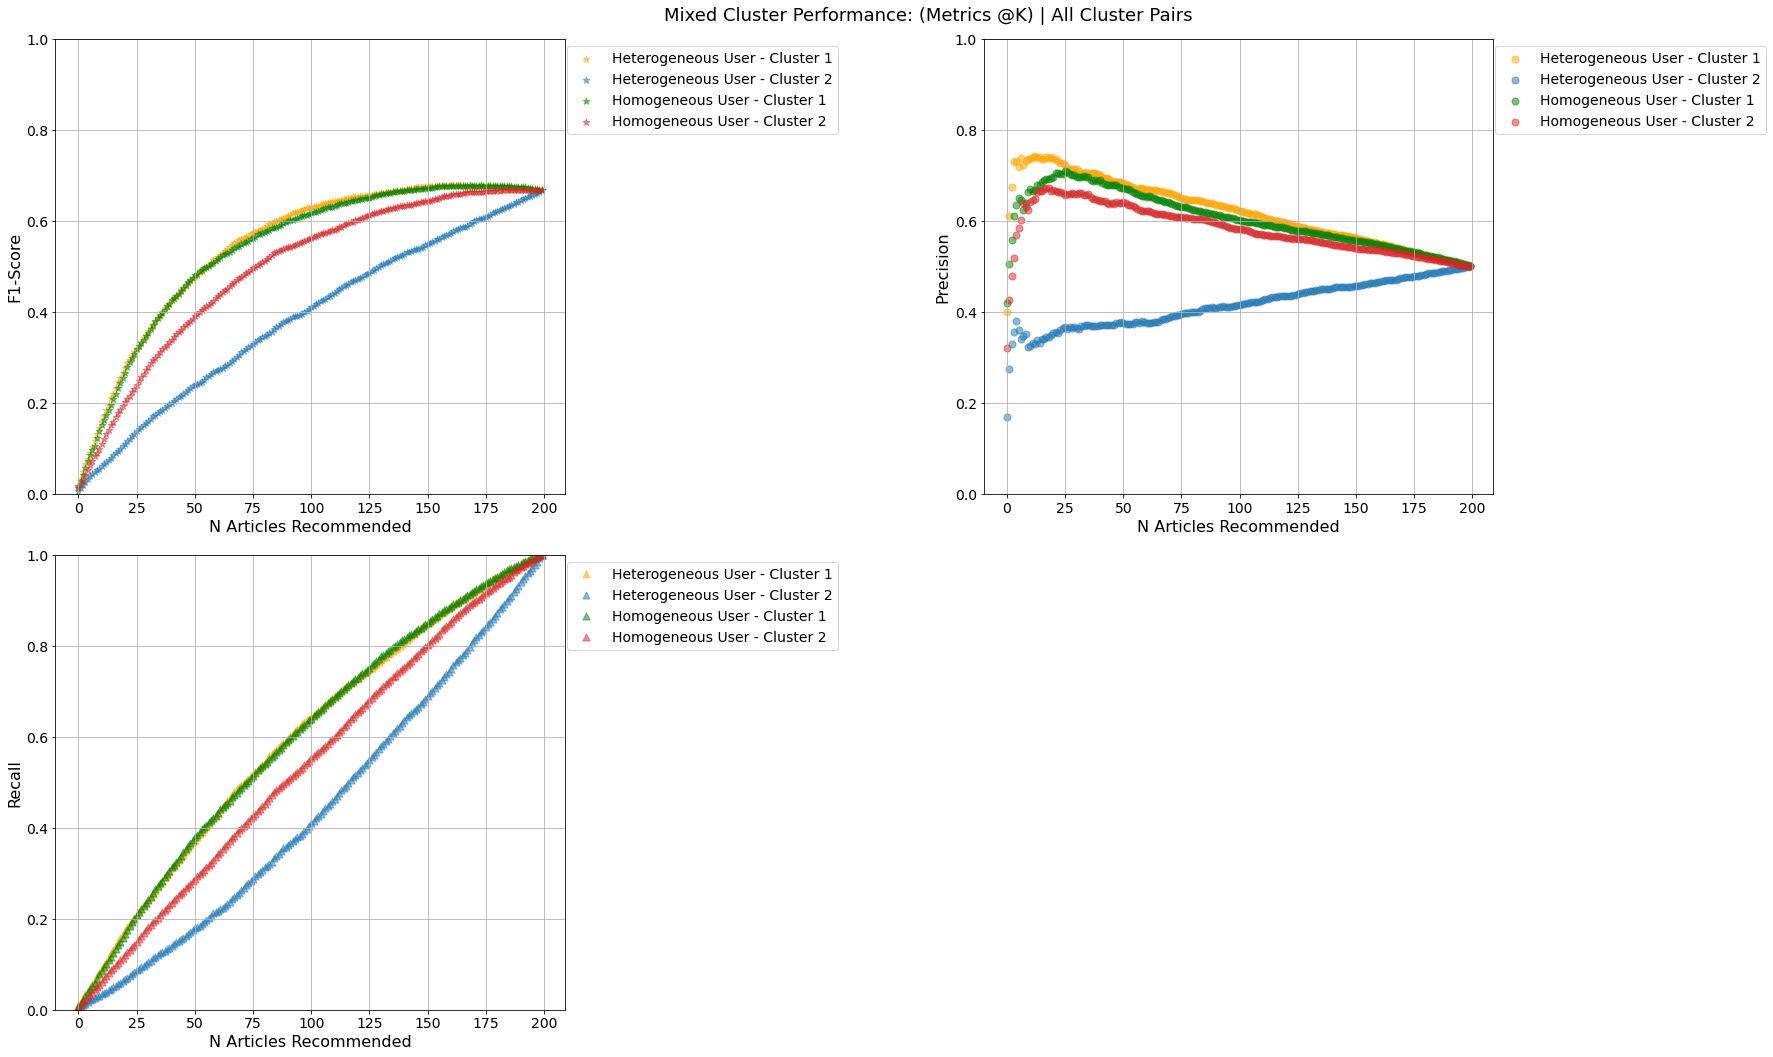


Finished running 'plot_mixed_data_performance_per_cluster' in 0.0102 mins


Finished running 'plot_mixed_cluster_cumulative_per_cluster' in 0.0105 mins



In [49]:
plot_mixed_cluster_cumulative_per_cluster(homo_scores,hetero_scores)

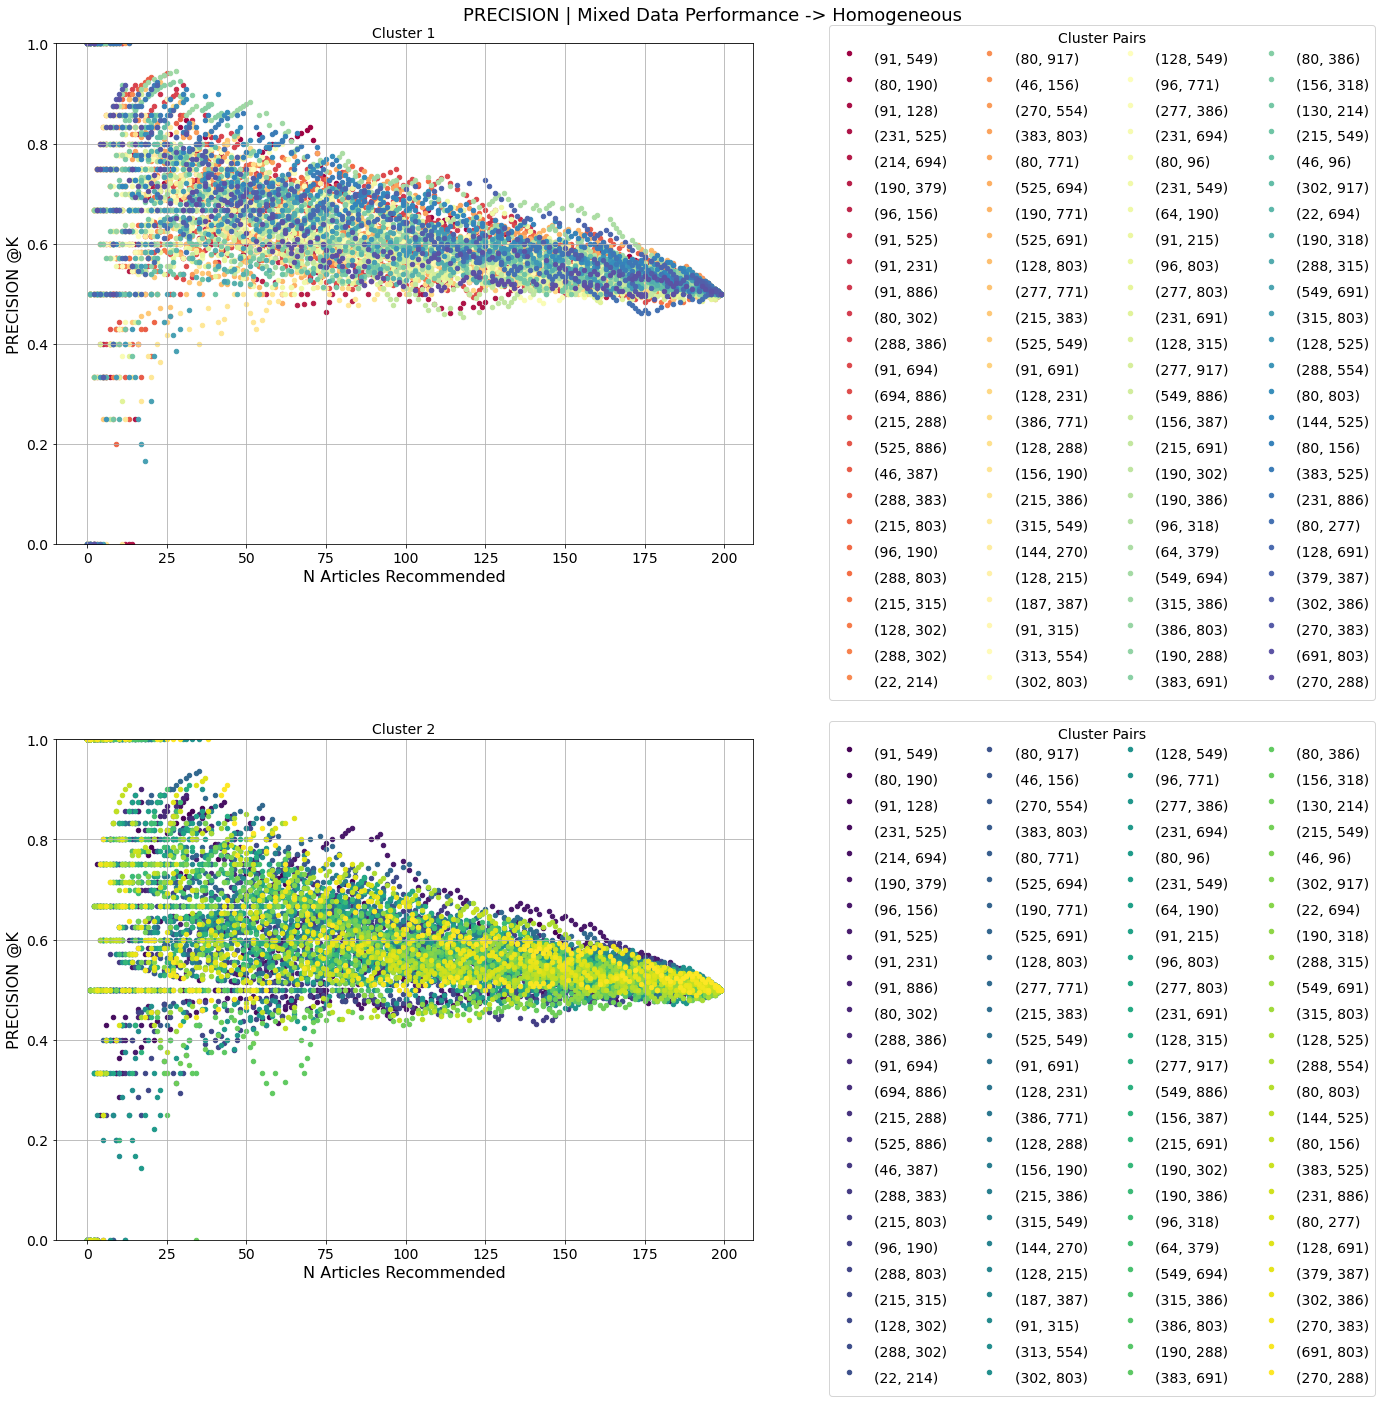


Finished running 'plot_mixed_data_all_cp_perf' in 0.1143 mins



In [50]:
plot_mixed_data_all_cp_perf(scores_cp=homo_scores,user_type="Homogeneous",metric="precision")

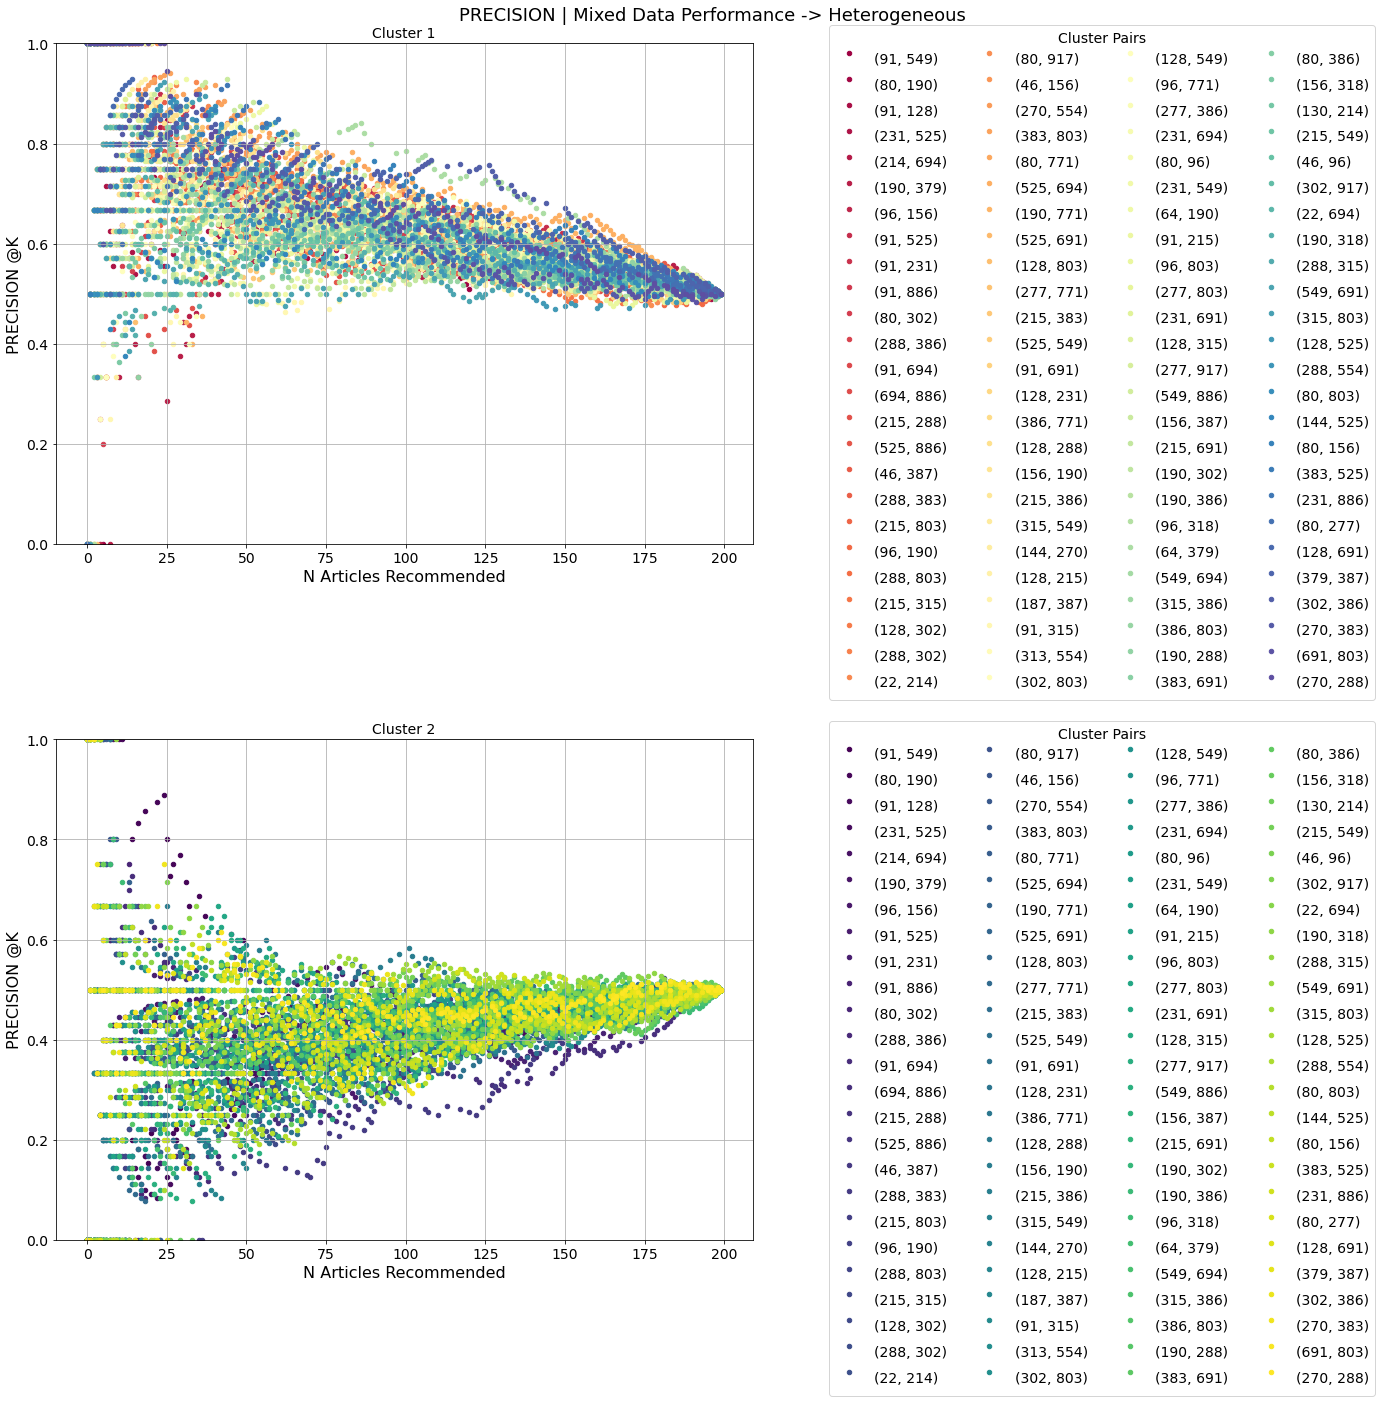


Finished running 'plot_mixed_data_all_cp_perf' in 0.1153 mins



In [51]:
plot_mixed_data_all_cp_perf(scores_cp=hetero_scores,user_type="Heterogeneous",metric="precision")

In [52]:
avg_presc_homo,avg_presc_homo_c1, avg_presc_homo_c2 = calculate_avg_precision(homo_scores,mode="mixed")

In [53]:
np.mean(avg_presc_homo)

0.5967130269500536

In [54]:
np.mean(avg_presc_homo_c1)

0.6035238557074298

In [55]:
np.mean(avg_presc_homo_c2)

0.5805252364633052

In [56]:
avg_presc_hetero,avg_presc_hetero_c1, avg_presc_hetero_c2 = calculate_avg_precision(hetero_scores,mode="mixed")

In [57]:
np.mean(avg_presc_hetero)

0.5279958123093847

In [58]:
np.mean(avg_presc_hetero_c1)

0.6205174232322117

In [59]:
np.mean(avg_presc_hetero_c2)

0.41559013610423323

## Baseline 7 : <a class="anchor" id="Learning_Rate_vs_Online_Setting_Mixed_Data_Performance"></a>

In [60]:
hetero_scores = run_bs7_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [61]:
homo_scores = run_bs7_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [62]:
# plot_lr_vs_metrics_at_k_mixed(homo_scores[(585, 712)],
#                                     lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],user_type="Homogeneous")

In [63]:
# plot_lr_vs_metrics_at_k_mixed(hetero_scores[(585, 712)],
#                                     lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0006 mins



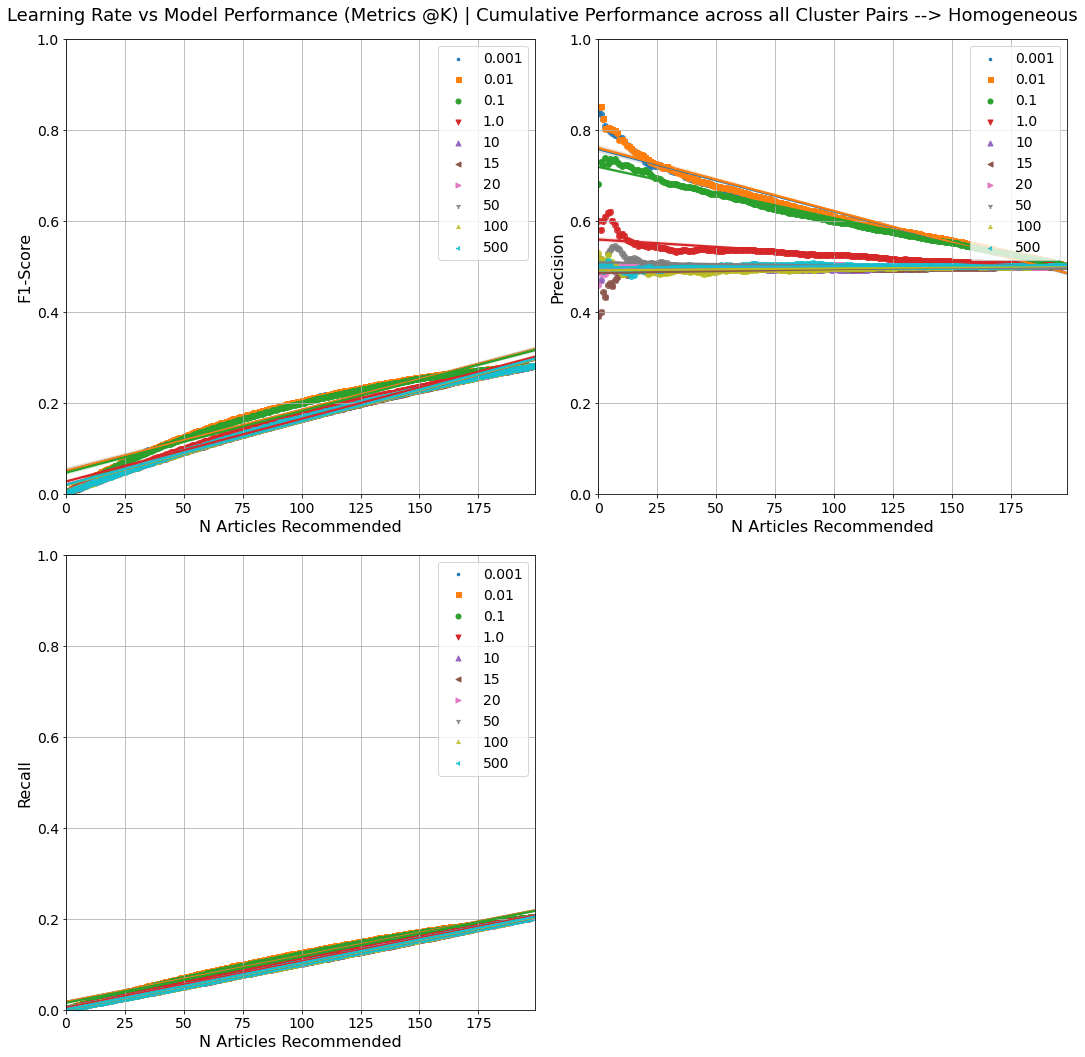


Finished running 'plot_lr_vs_metrics_at_k' in 0.0657 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0663 mins



In [64]:
plot_lr_vs_metrics_at_k_cumu(homo_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
                             user_type="Homogeneous",mixed_data=True)


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0006 mins



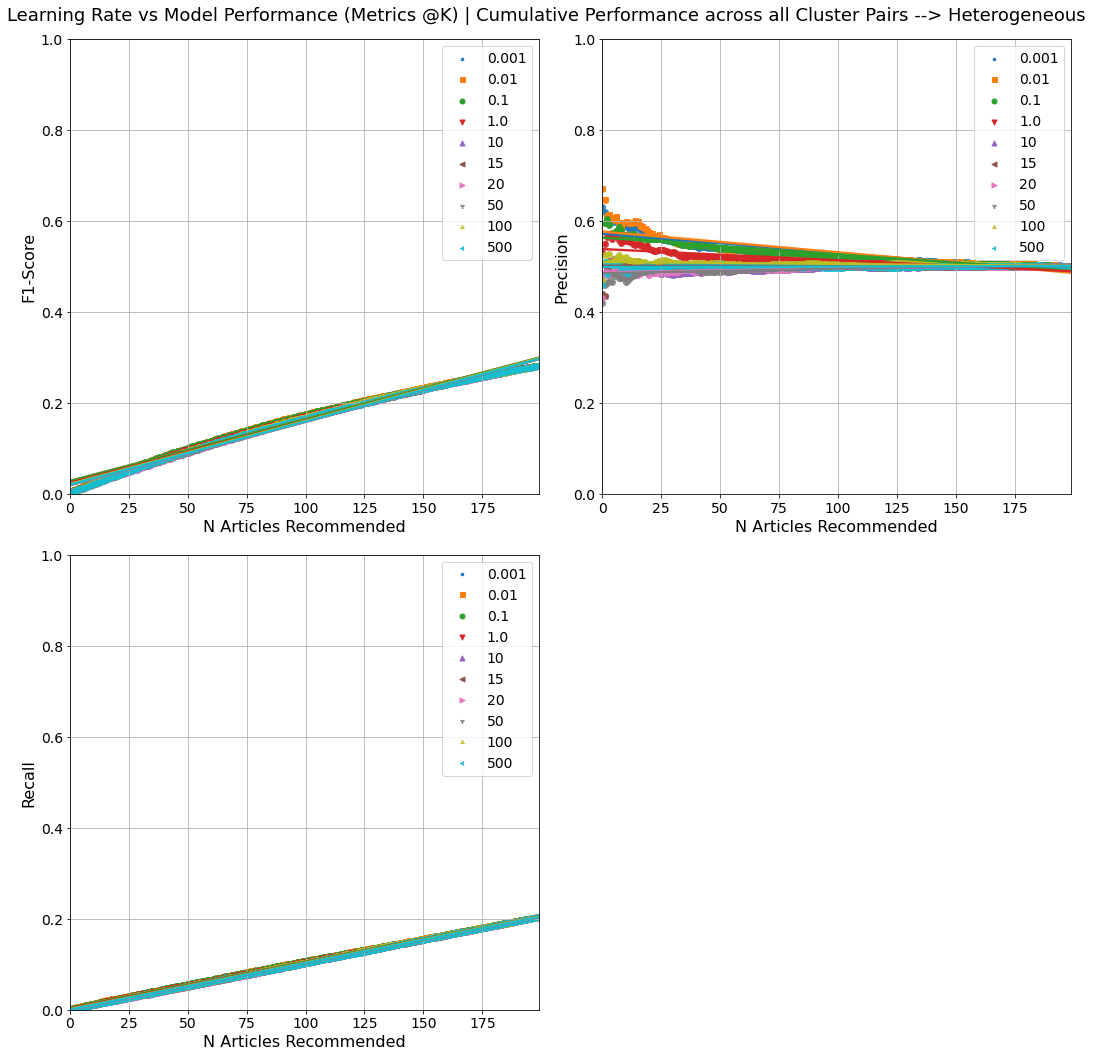


Finished running 'plot_lr_vs_metrics_at_k' in 0.0663 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0669 mins



In [65]:
plot_lr_vs_metrics_at_k_cumu(hetero_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],mixed_data=True)

In [66]:
#  plot_mixed_data_all_cp_precis_lr(scores_=homo_scores,
#                              lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
#                              user_type="Homogeneous",metric="precision")

In [67]:
#  plot_mixed_data_all_cp_precis_lr(scores_=hetero_scores,
#                              lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
#                              user_type="Heterogeneous",metric="precision")

In [68]:
homo_param_res = calculate_avg_precision_param_variation(homo_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],mode="mixed")

In [69]:
calculate_map_param_variation(homo_param_res,mode="mixed")


Param : 0.001
0.6209994857899597
c1 MAP : 
0.6338964877282016
c2 MAP : 
0.5954523060462837

Param : 0.01
0.6223005463565245
c1 MAP : 
0.6347914924753313
c2 MAP : 
0.598757713060598

Param : 0.1
0.6062402760185053
c1 MAP : 
0.6195426874506448
c2 MAP : 
0.5862879043216105

Param : 1.0
0.526660976853529
c1 MAP : 
0.5310842186585932
c2 MAP : 
0.5139711013340559

Param : 10
0.49510847637468786
c1 MAP : 
0.49368581712919224
c2 MAP : 
0.49258296350110653

Param : 15
0.4936360499564801
c1 MAP : 
0.48479061850485294
c2 MAP : 
0.49782932294574705

Param : 20
0.49913412305897553
c1 MAP : 
0.49789429042271466
c2 MAP : 
0.4974080664966874

Param : 50
0.5013386381644557
c1 MAP : 
0.49367027536376307
c2 MAP : 
0.5025298812535438

Param : 100
0.49563939007529884
c1 MAP : 
0.491586456701188
c2 MAP : 
0.4946004309789441

Param : 500
0.5001320722431809
c1 MAP : 
0.4893631648178816
c2 MAP : 
0.5061828994543093


In [70]:
hetero_param_res = calculate_avg_precision_param_variation(hetero_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],mode="mixed")

In [71]:
calculate_map_param_variation(hetero_param_res,mode="mixed")


Param : 0.001
0.5296718500643824
c1 MAP : 
0.6313403926908729
c2 MAP : 
0.3898537781772963

Param : 0.01
0.5310655324261327
c1 MAP : 
0.6317604374904502
c2 MAP : 
0.39084761271030943

Param : 0.1
0.5264937847314374
c1 MAP : 
0.614208935956514
c2 MAP : 
0.4066362979552597

Param : 1.0
0.5135438744716395
c1 MAP : 
0.5258947151953469
c2 MAP : 
0.49313702771415996

Param : 10
0.4941402879023446
c1 MAP : 
0.4874738114557457
c2 MAP : 
0.49610861706147347

Param : 15
0.5005887496713745
c1 MAP : 
0.4996766443007917
c2 MAP : 
0.49725290332305866

Param : 20
0.49561309495561945
c1 MAP : 
0.49273614224638324
c2 MAP : 
0.4912541095642139

Param : 50
0.4947746211066148
c1 MAP : 
0.4901000689300533
c2 MAP : 
0.4938254623980889

Param : 100
0.5052182481421754
c1 MAP : 
0.5064948302963542
c2 MAP : 
0.501067576291645

Param : 500
0.4995148281795326
c1 MAP : 
0.4972187244557891
c2 MAP : 
0.4958352957473035
